In [38]:
import os
import sys

home_path = '/home/giorgio/venvs/SHREC'
if home_path not in sys.path:
    sys.path.append(home_path)

from format import Text
import pandas as pd
from pathlib import Path
from datasetStudy import *

import lzma
import torch
import torch.nn as nn
import torch.nn.functional as F
from symmetria.encoders.pointnet_encoder import PointNetEncoder

from symmetria.encoders.pointnext.pointnext_encoder_parameters import *
from symmetria.encoders.pointnext.pointnext_encoder import PointNeXt

from symmetria.decoders.prediction_head import PredictionHead

root = Path('/mnt/dataset/shrec-2025-protein-classification/v2-20250331')

debug_pointnet = False

if debug_pointnet:
    bs, sz = 1, 2048
    encoder = PointNetEncoder(use_bn=False)
    mock_x = torch.randn(bs, 3, sz)
    output = encoder.forward(mock_x)
    print(f'{Text(output, 'output'):inspect}')

    decoder = PredictionHead(1024, 96)
    output_decoder = decoder.forward(output)
    print(f'{Text(output_decoder, 'output_decoder'):inspect}')

class PointNet(nn.Module):
    def __init__(self, output_size, max_points, use_bn=False, encoder='pointnet'): # make it prettier like in segmenter
        super().__init__()
        
        if encoder in POINTNEXT_MODEL_CONFIG:
            model_cfg = POINTNEXT_MODEL_CONFIG[encoder]     # 'PointNeXt_B' (21.5 M), 'PointNeXt_L2' (32.0 M), 'PointNeXt_XXL' (73.8 M)
            self.encoder = PointNeXt(model_cfg)
            self.encoder_output_size = output_size          # because of the adapter head (e.g. 2048 -> 1024) within the encoder
            print(f"Using PointNeXt {model_cfg} - encoder: {self.encoder}")
        else:
            self.encoder = PointNetEncoder(use_bn)
            print(f"Using PointNet as encoder - encoder: {self.encoder}")
        
        self.max_points = max_points

        self.input_size = self.get_input_size()        
        self.output_size = output_size

        print(f'Creating a PredictionHead with {self.input_size} as input and {self.output_size} as output')
        self.decoder = PredictionHead(self.input_size, self.output_size, use_bn, use_relu=True)
        
        #self.softmax = nn.Softmax(dim=1)

    def get_input_size(self):
        mock_x = torch.randn(1, 3, self.max_points)
        return self.encoder(mock_x).shape[-1]

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        #x = self.softmax(x)

        return x #SoftMax already inside the CrossEntropyLoss

In [56]:
from tqdm import tqdm
from symmetria.transforms.UnitSphereNormalization import UnitSphereNormalization
from symmetria.transforms.RandomSampler import RandomSampler

class Predictor():
    def __init__(self, df_test, df_train, models, max_points, root=root):
        self.df_test = df_test
        self.df_train = df_train
        self.models = []

        for model in models:
            model.eval()
            self.models.append(model)
        
        self.max_points = max_points
        self.root_test = root / 'test'
        self.root_train = root / 'train-xz'
        
        self.normalizer = UnitSphereNormalization()
        self.sampler = RandomSampler(sample_size=max_points)
        
        self.test_run = 0 
        
    def predict(self, test=True, get_logits=False):
        prediction_column_name = 'Run'
        logits_column_name = 'Logits'

        if test:
            df = self.df_test
        else:
            df = self.df_train

        pred_col = []
        logit_col = []

        for idx in tqdm(range(len(df))):
            if test:
                protein_id = df['anonymised_protein_id'].loc[idx]
                point_cloud = self.get_vtk_points(protein_id)
            
            else:
                protein_id, cls, nop = df['protein_id'].loc[idx], df['class_id'].loc[idx], df['number_of_points'].loc[idx]
                point_cloud = self.get_xz_points(protein_id, cls=cls, nop=nop)

            prediction, prediction_logits = self.pass_to_model(point_cloud)

            pred_col.append(int(prediction.cpu()))
            logit_col.append(prediction_logits.cpu().detach().numpy())
        
        df[prediction_column_name] = pred_col
        if get_logits:
            df[logits_column_name] = logit_col

    def pass_to_model(self, point_cloud):

        point_cloud_t = torch.from_numpy(point_cloud).to(torch.device('cuda:0'))     
        point_cloud_t = point_cloud_t.type(torch.float32)

        point_cloud_t = self.normalizer(point_cloud_t)
        point_cloud_t = self.sampler(point_cloud_t)
        point_cloud_t = torch.transpose(point_cloud_t, 0, 1)

        prediction_logits = 0
        for model in self.models:
            prediction_logits += model(point_cloud_t.view(1, *point_cloud_t.shape))
        
        #prediction_logits =  prediction_logits/len(self.models)
        return torch.argmax(prediction_logits, dim=1), prediction_logits

    def get_vtk_points(self, name):
        prot_file = name
        prot_file = os.path.join(self.root_test, prot_file)
        
        prot_mesh = pv.read(prot_file)

        return prot_mesh.points
    
    def get_xz_points(self, name, cls, nop=None, debug=False):
        cls = str(cls)
        nop = str(nop) if nop and nop != 'nan' else None

        while len(cls) < 2:
            cls = '0' + cls
        
        if nop and nop != 'nan':
            while len(nop) < 6:
                nop = '0' + nop

        if nop and nop != 'nan':
            prot_file = cls + '-' + nop +  '-' + name.replace(':', '+') + '.xz'
        else:
            prot_file = cls + '-' + name.replace(':', '+') + '.xz'
        if debug:
            print(f'ProteinDataset is loading files from {self.root_train}')
        prot_file = os.path.join(self.root_train, prot_file)        
        
        with lzma.open(prot_file, 'rt') as f:
            point_cloud = np.loadtxt(f)
    
        return point_cloud
    
    def get_confusion_matrix(self):
        output_size = self.models[0].output_size
        self.cm = np.zeros((output_size, output_size), dtype=np.int64)

        target, output = self.df_train['class_id'], self.df_train['Run']

        for targ, pred in zip(target, output):
            self.cm[targ][pred] += 1

    # Refactor to make it save multiple things
    def save_predictions_on_test(self, name):
        self.df_test.to_csv(name)
    



In [63]:
models = [PointNet(97, max_points=4000).to(torch.device('cuda:0')),
          PointNet(97, max_points=4000).to(torch.device('cuda:0')),
          PointNet(97, max_points=4000).to(torch.device('cuda:0'))]

path_to_weights = [Path('/home/giorgio/venvs/SHREC/notebooks/output/run_shrec-2025_08042025_122841_train_set_comprehensive/model_80.pth'),
                   Path('/home/giorgio/venvs/SHREC/notebooks/output/run_shrec-2025_08042025_122841_train_set_comprehensive/model_final.pth'),
                   Path('/home/giorgio/venvs/SHREC/notebooks/output/run_shrec-2025_08042025_122841_train_set_comprehensive/model_best_loss.pth')]

for model, path in zip(models, path_to_weights):
    model.load_state_dict(torch.load(path, map_location=torch.device('cuda:0')))

Using PointNet as encoder - encoder: PointNetEncoder(
  (input_transform): TNet(
    (shared_mlps): Sequential(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (5): ReLU()
    )
    (linear): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=9, bias=True)
    )
  )
  (feature_transform): TNet(
    (shared_mlps): Sequential(
      (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (5): ReLU()
    )
    (linear): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
     

In [64]:
test_df = pd.read_csv(root / 'test_set.csv')
train_df = pd.read_csv('/home/giorgio/venvs/SHREC/datasets/train_set-all.csv')

predi = Predictor(test_df, train_df, models, max_points=4000)
predi.predict(test=True)
predi.predict(test=False)

100%|██████████| 9244/9244 [02:57<00:00, 52.19it/s]


In [25]:
predi.save('/home/giorgio/venvs/SHREC/prediction_on_test-train_set_all_comprehensive-run_08042025_122841-model_final+80+bestloss.csv')

In [ ]:
df = pd.read_csv('../prediction_on_test-train_set_all_pretrained-run_09042025_135413-model_final.csv')

dist_test = cls_distribution(predi.df_test, column_name='Run')
dist_train = cls_distribution(predi.df_train)
dist_train_pred = cls_distribution(predi.df_train, column_name='Run')

for cls in range(97):
    if cls in dist_test.keys():
        continue
    else:
        dist_test[np.int64(cls)] = 0
    
    if cls in dist_train_pred.keys():
        continue
    else:
        dist_train_pred[np.int64(cls)] = 0

dist_train_normalized = []
dist_test_normalized = []
dist_train_pred_normalized = []
errors = []
for cls in range(97):
    train_f = dist_train[cls]/len(predi.df_train)
    test_f = dist_test[cls]/len(predi.df_test)
    train_pred_f = dist_train_pred[cls]/len(predi.df_train)
    dist_train_normalized.append(train_f)
    dist_test_normalized.append(test_f)
    dist_train_pred_normalized.append(train_pred_f)

    err = np.abs(train_f - test_f)/train_f * 100
    errors.append(err)
    print(f'{cls}: {train_f = :.5f}\t{test_f = :.5f}\t{err = :.2f}')


print(f'Mean error: {np.mean(errors):.2f}')
histogram = {'Train_dist': dist_train_normalized, 'Test_dist': dist_test_normalized, 'Train_dist_pred': dist_train_pred_normalized}
histo = pd.DataFrame(data=histogram)


0: train_f = 0.01093	test_f = 0.01163	err = 6.47
1: train_f = 0.00032	test_f = 0.00043	err = 32.76
2: train_f = 0.00184	test_f = 0.00129	err = 29.72
3: train_f = 0.00227	test_f = 0.00172	err = 24.14
4: train_f = 0.00162	test_f = 0.00172	err = 6.21
5: train_f = 0.01374	test_f = 0.01293	err = 5.92
6: train_f = 0.00270	test_f = 0.00215	err = 20.34
7: train_f = 0.00811	test_f = 0.00732	err = 9.72
8: train_f = 0.22220	test_f = 0.22792	err = 2.57
9: train_f = 0.00714	test_f = 0.00862	err = 20.69
10: train_f = 0.00151	test_f = 0.00129	err = 14.66
11: train_f = 0.00465	test_f = 0.00474	err = 1.88
12: train_f = 0.00108	test_f = 0.00043	err = 60.17
13: train_f = 0.00238	test_f = 0.00129	err = 45.69
14: train_f = 0.05290	test_f = 0.04955	err = 6.34
15: train_f = 0.00963	test_f = 0.00991	err = 2.93
16: train_f = 0.01666	test_f = 0.01637	err = 1.72
17: train_f = 0.01255	test_f = 0.01336	err = 6.44
18: train_f = 0.00822	test_f = 0.00776	err = 5.67
19: train_f = 0.00454	test_f = 0.00560	err = 23.28
2

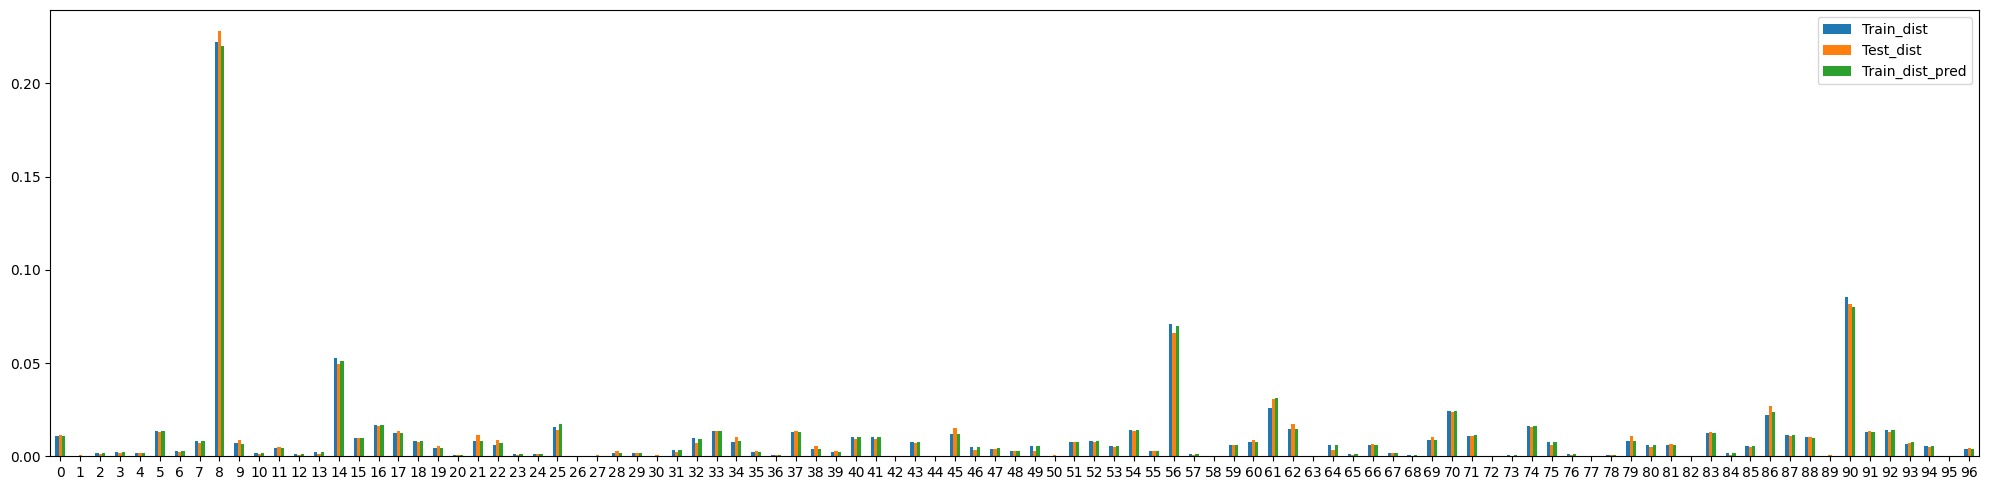

In [77]:
import matplotlib.pyplot as plt

histo.plot.bar(rot=0, figsize=(20, 5))
plt.tight_layout() # fit labels etc. nicely into the plot
plt.show()

In [67]:
predi.df_test.to_csv('/home/giorgio/venvs/SHREC/prediction_on_test-train_set_all_comprehensive-run_08042025_122841-model_final+80+bestloss+newrun.csv')

In [69]:
predi.get_confusion_matrix()

In [74]:
conf_matrix = pd.DataFrame(predi.cm, index=[i for i in range(97)], columns=[i for i in range(97)])
conf_matrix.to_csv('confusion_matrix.csv')